# Python Statistics

## 1. Carregar bibliotecas e funções

In [1]:
# Bibiotecas padrão
import pandas as pd
import numpy as np

## Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp

# Escrever as fórmulas dos modelos
import patsy as pt

# Fator de inflação da variância
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Bibliotecas do scikitlearn para calcular as métricas e fazer a regressão regularizada
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV

In [7]:
def desc_null(df, percentiles=False):
  """
  Função para descrição de dados, incluindo colunas de contagem de nulos e porcentagem de nulos em cada variável
  """
  if percentiles is True:
    des = df.describe(datetime_is_numeric=True,
                      percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.99]).T
    des["nullCount"] = df.shape[0] - des["count"]
    des["null%"] = (des["nullCount"] / df.shape[0]) * 100

  else:
    des = df.describe(include='all', 
                      datetime_is_numeric=True).T
    des['nullCount'] = df.shape[0] - des['count']
    des['null%'] = (des['nullCount'] / df.shape[0]) * 100
    
  return des

In [17]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

## 2. Carregar os dados

**Database**: https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

Contém informações sobre carros e gasto de combustível

In [4]:
# Database
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

## Nomenclatura das colunas: https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names
cols = ['mpg', 'cyl', 'disp', 'hp', 'weight', 'acc', 'year', 'origin', 'name']

In [5]:
# Read table para visualizar dados delimitados por espaço
df = pd.read_table(url, header=None, 
                   delim_whitespace=True, 
                   names=cols)

In [6]:
df.head()

,mpg,cyl,disp,hp,weight,acc,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## 3. Exploratory Data Analysis - Análise Exploratória de dados

A base de dados não possui valores nulos e possui 398 entradas.

| **Feature**  | **Descrição**                                               | **Tipo**   | **Range**    | **Valores únicos**                              
| :----------: | ----------------------------------------------------------- | :--------: | :----------: | ------------------ 
| mpg          | Quantidade de milhas por galão de gasolina                  | Numérico   | 9.0 - 46.6   | 
| cyl          | Quantidade de cilindros no motor do carro                   | Numérico   | 3 - 8        |     
| disp         | Quantidade de força que o motor pode gerar                  | Numérico   | 68  - 455    | 
| hp           | Cavalos de força do motor                                   | Numérico   |              | 94  
| weight       | Peso do veículo (lb/1000)                                   | Numérico   | 1613 - 5140  |  
| acc          | Aceleração                                                  | Numérico   | 8.0 - 24.8   | 
| year         | Ano de fabricação do veículo                                | Categórico | 70 - 82      |
| origin       | Origem do carro:  1. Americano, 2. Europeu e 3. Japones     | Categórico |   1 - 3      | 
| name         | Nome do modelo                                              | Categórico |              | 305

In [10]:
desc_null(df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,nullCount,null%
mpg,398.0,NaN,NaN,NaN,23.514573,7.815984,9.0,17.5,23.0,29.0,46.6,0.0,0.0
cyl,398.0,NaN,NaN,NaN,5.454774,1.701004,3.0,4.0,4.0,8.0,8.0,0.0,0.0
disp,398.0,NaN,NaN,NaN,193.425879,104.269838,68.0,104.25,148.5,262.0,455.0,0.0,0.0
hp,398,94,150.0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
weight,398.0,NaN,NaN,NaN,2970.424623,846.841774,1613.0,2223.75,2803.5,3608.0,5140.0,0.0,0.0
acc,398.0,NaN,NaN,NaN,15.56809,2.757689,8.0,13.825,15.5,17.175,24.8,0.0,0.0
year,398.0,NaN,NaN,NaN,76.01005,3.697627,70.0,73.0,76.0,79.0,82.0,0.0,0.0
origin,398.0,NaN,NaN,NaN,1.572864,0.802055,1.0,1.0,1.0,2.0,3.0,0.0,0.0
name,398,305,ford pinto,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


### 3.1. Separação das variáveis

#### 3.1.1. Variáveis categóricas

Separar as variáveis categóricas para análise posterior.

In [12]:
cat = ['year', 'origin', 'name']

for c in cat:
    df[c] = df[c].astype('category')

df[cat].head()

,year,origin,name
0,70,1,chevrolet chevelle malibu
1,70,1,buick skylark 320
2,70,1,plymouth satellite
3,70,1,amc rebel sst
4,70,1,ford torino


#### 3.1.2. Variáveis numéricas

A variável **hp** constava com objeto, sendo necessário trocar o valor **?** por **np.nan** e realizar a conversão para float.

In [34]:
df['hp'].replace(to_replace='?', 
                 value=np.nan, 
                 inplace=True)

df['hp'] = df['hp'].astype('float64')

num = list(df.select_dtypes(include='number'))
num.remove('mpg')

In [36]:
desc_null(df[num], percentiles=True)

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max,nullCount,null%
cyl,398.0,5.454774,1.701004,3.0,4.000,4.000,4.0,8.000,8.0,8.000,8.0,0.0,0.000000
disp,398.0,193.425879,104.269838,68.0,85.000,104.250,148.5,262.000,350.0,440.420,455.0,0.0,0.000000
hp,392.0,104.469388,38.491160,46.0,60.550,75.000,93.5,126.000,157.7,220.450,230.0,6.0,1.507538
weight,398.0,2970.424623,846.841774,1613.0,1923.500,2223.750,2803.5,3608.000,4275.2,4951.030,5140.0,0.0,0.000000
acc,398.0,15.568090,2.757689,8.0,11.285,13.825,15.5,17.175,19.0,22.239,24.8,0.0,0.000000


#### 3.1.3. Variável resposta

In [37]:
resp = ['mpg']

df[resp].head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


### 3.2. Distribuição das variáveis

In [45]:
def histplot(data, title=None, xlabel=None, ylabel=None, x=None, y=None, ax=True, nrows=1, ncols=1, figsize=(10, 5), bins=10):
  """
  Fast histplot configuration
  """
  import matplotlib.pyplot as plt
  import seaborn as sns
  
  if ax is True:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    c = 0
    if nrows > 1 and ncols > 1:
      for i in range(nrows):
        for j in range(ncols):
          sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i,j]).set_ylabel(ylabel)
          c += 1
    elif nrows == 1:
      for j in range(ncols):
        sns.histplot(data=data, 
                     x=x[c], 
                     y=y, 
                     bins=bins, 
                     ax=axes[j]).set_ylabel(ylabel)
        c += 1
    elif ncols == 1:
      for i in range(nrows):
        sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i]).set_ylabel(ylabel)
        c += 1
  
  else:
    plt.figure(figsize=figsize)
    sns.histplot(data=data, x=x, y=y, bins=bins)
    
    if title is not None:
      plt.title(title)
    if xlabel is not None:
      plt.xlabel(xlabel)
    if ylabel is not None:
      plt.ylabel(ylabel)
      

  return plt.show()

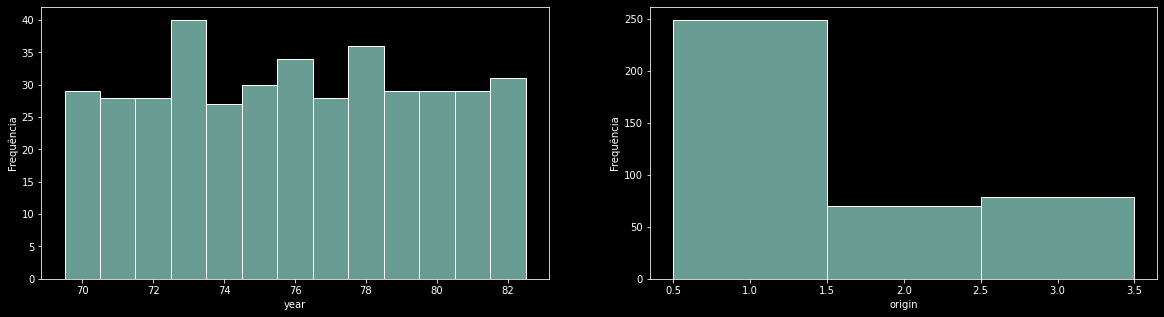

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
c = 0

for j in range(2):
        sns.histplot(data=df[cat], 
                     x=['year', 'origin'][c], 
                     ax=axes[j]).set_ylabel('Frequência')
        c += 1

plt.show()

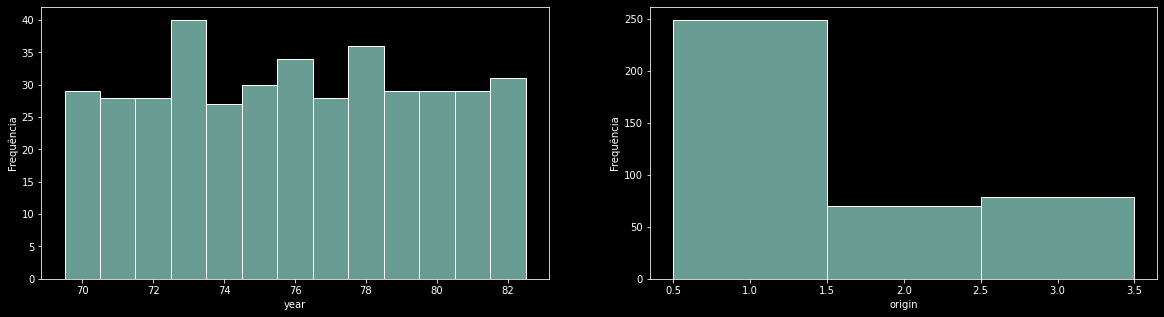

In [46]:
histplot(data=df[cat], 
         title='Distribuição das variáveis categóricas', 
         ylabel='Frequência',
         x=['year', 'origin'], ax=True,
         ncols=2,
         figsize=(20,5))